# Final Project: Advanced Programming DATA 602

Andrew Bowen    
CUNY School of Professional Studies    
DATA602: Advanced Programming Techniques    

## Introduction
The long-term trend of [declining poverty rates in the United States has reversed in the past few years](https://www.census.gov/newsroom/stories/poverty-awareness-month.html)

## Data Sources

I found open-source datasets included on [NYCOpen Data](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi3uZnsrJr-AhVrkIkEHToLAkwQFnoECAYQAQ&url=https%3A%2F%2Fopendata.cityofnewyork.us%2F&usg=AOvVaw3hMgMsrOdIKW8WMDwBACaY). I chose this dataset showing the [financial health of different NYC neighborhoods](https://data.cityofnewyork.us/Business/Neighborhood-Financial-Health-Digital-Mapping-and-/r3dx-pew9). This dataset includes the median salary, as well as other demographic indicators. This dataset is based off of [NYC's Neighborhood Financial Health mapping tool](https://www.nyc.gov/assets/dca/NFHI/NFHI/Index.html). I uploaded the CSV of this dataset to my [GitHub](https://raw.githubusercontent.com/andrewbowen19/advancedProgrammingData602/main/data/nyc-poverty-puma.csv) for the ability for others to reproduce. 


- [Financial Health by NYC Neighborhood](https://data.cityofnewyork.us/Business/Neighborhood-Financial-Health-Digital-Mapping-and-/r3dx-pew9) 💰
- [NYC PUMA Boundaries](https://data.cityofnewyork.us/Housing-Development/2010-Public-Use-Microdata-Areas-PUMAs-/cwiz-gcty) 🗺️

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas


In [17]:
# Reading in file from github
file_path = "https://raw.githubusercontent.com/andrewbowen19/advancedProgrammingData602/main/data/nyc-poverty-puma.csv"

df = pd.read_csv(file_path)

df.head()

,Year Published,PUMA,Borough,Neighborhoods,CD,Join,NYC_Poverty_Rate,Median_Income,Perc_White,Perc_Black,...,Ind6Rank,Ind6Definition,Ind7,Ind7Outcome,Ind7Rank,Ind7Definition,Ind8,Ind8Outcome,Ind8Rank,Ind8Definition
0,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,32.0,Percentage of jobs in small businesses (less t...,Participatory Budgeting,0.071777,26.0,Percentage of eligible residents casting a vot...,NaN,NaN,NaN,NaN
1,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,38.0,Percentage of bank & credit union branches off...,Mobile Banking Utilization,0.205800,23.0,Estimated percentage of residents that used mo...,NaN,NaN,NaN,NaN
2,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,27.0,Number of pre-foreclosure notices issued per 1...,Financial Counseling,0.000000,40.0,Full-Time Equivalent Financial Counselors per ...,NaN,NaN,NaN,NaN
3,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,41.0,Average (mean) travel time to work in minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,28.0,Percentage of people eligible for SNAP receivi...,Tax Credit Utilization,0.966000,9.0,Percentage of eligible Tax Units claiming EITC,Adults With High School Diploma,0.845032,21.0,Percentage of adults with a high school degree...


## Data Cleaning
We'll need to perform some cleaning steps on our data

- Convert columns to `snake_case`
- Handle missing values in numeric columns
- Join our income data to our NYC 

In [18]:
# convert dataframe columns to snake_case
new_cols = [c.replace(" ", "_").lower() for c in df.columns]
df.columns = new_cols

# clean some edge case columns
renamed_cols = {"yearpublished": "year_published"}
df = df.rename(columns=renamed_cols)

df.head()

,year_published,puma,borough,neighborhoods,cd,join,nyc_poverty_rate,median_income,perc_white,perc_black,...,ind6rank,ind6definition,ind7,ind7outcome,ind7rank,ind7definition,ind8,ind8outcome,ind8rank,ind8definition
0,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,32.0,Percentage of jobs in small businesses (less t...,Participatory Budgeting,0.071777,26.0,Percentage of eligible residents casting a vot...,NaN,NaN,NaN,NaN
1,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,38.0,Percentage of bank & credit union branches off...,Mobile Banking Utilization,0.205800,23.0,Estimated percentage of residents that used mo...,NaN,NaN,NaN,NaN
2,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,27.0,Number of pre-foreclosure notices issued per 1...,Financial Counseling,0.000000,40.0,Full-Time Equivalent Financial Counselors per ...,NaN,NaN,NaN,NaN
3,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,41.0,Average (mean) travel time to work in minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,28.0,Percentage of people eligible for SNAP receivi...,Tax Credit Utilization,0.966000,9.0,Percentage of eligible Tax Units claiming EITC,Adults With High School Diploma,0.845032,21.0,Percentage of adults with a high school degree...


In [19]:
# Getting NYC shapefile to overlay plot
nyc = geopandas.read_file("puma_nyc_boundaries.zip")
nyc.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.112713,"POLYGON ((-73.89663 40.91142, -73.89663 40.911..."
1,3702,1.889936e+08,106167.615361,"POLYGON ((-73.79323 40.88282, -73.79417 40.882..."
2,3703,2.676248e+08,304580.313345,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
3,3704,1.062145e+08,47984.759911,"POLYGON ((-73.82834 40.86089, -73.82843 40.860..."
4,3705,1.224877e+08,68720.860104,"POLYGON ((-73.87056 40.87151, -73.87054 40.869..."


Now we'll join our income data (`df`) to our `nyc` geopandas dataframe.

[]

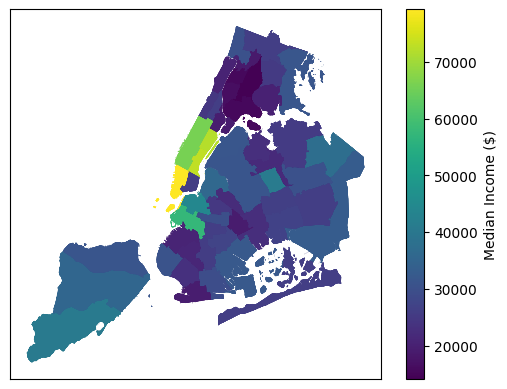

In [20]:
# Joining dtaa on puma key
nyc['puma'] = nyc.puma.astype(int)
nyc = pd.merge(nyc, df[['puma',
                        'median_income',
                        'perc_white', 
                        'perc_black',
                        'perc_hispanic',
                        'perc_asian',
                        'perc_other',
                        'nyc_poverty_rate']], on='puma', how='left')

# Plotting median income by PUMA choropleth
f, ax = plt.subplots()
nyc.plot(column='median_income', ax=ax, legend=True,
                legend_kwds={'label': "Median Income ($)",
                             'orientation': "vertical"})

# Removing lat & long for cleaner plot
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title("NYC Median Income by Municipal Area")

We could also plot the poverty rate (`nyc_poverty_rate`) column present in our data by NYC neighborhood

Text(0.5, 1.0, 'NYC Poverty Rate by Municipal Area')

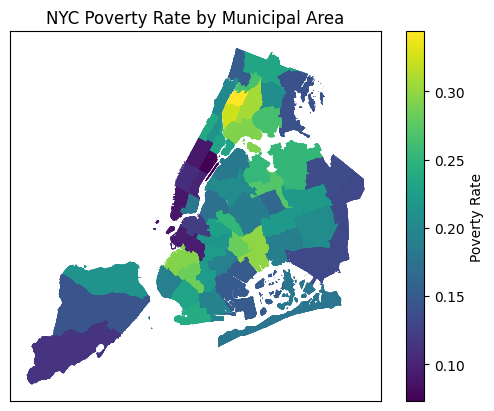

In [23]:
# Plotting poverty rate by 
f, ax = plt.subplots()
nyc.plot(column='nyc_poverty_rate', ax=ax, legend=True,
                legend_kwds={'label': "Poverty Rate",
                             'orientation': "vertical"})

# Cleaning up graph ticks and labels
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title("NYC Poverty Rate by Municipal Area")

Text(0, 0.5, 'Median income by neighborhood ($)')

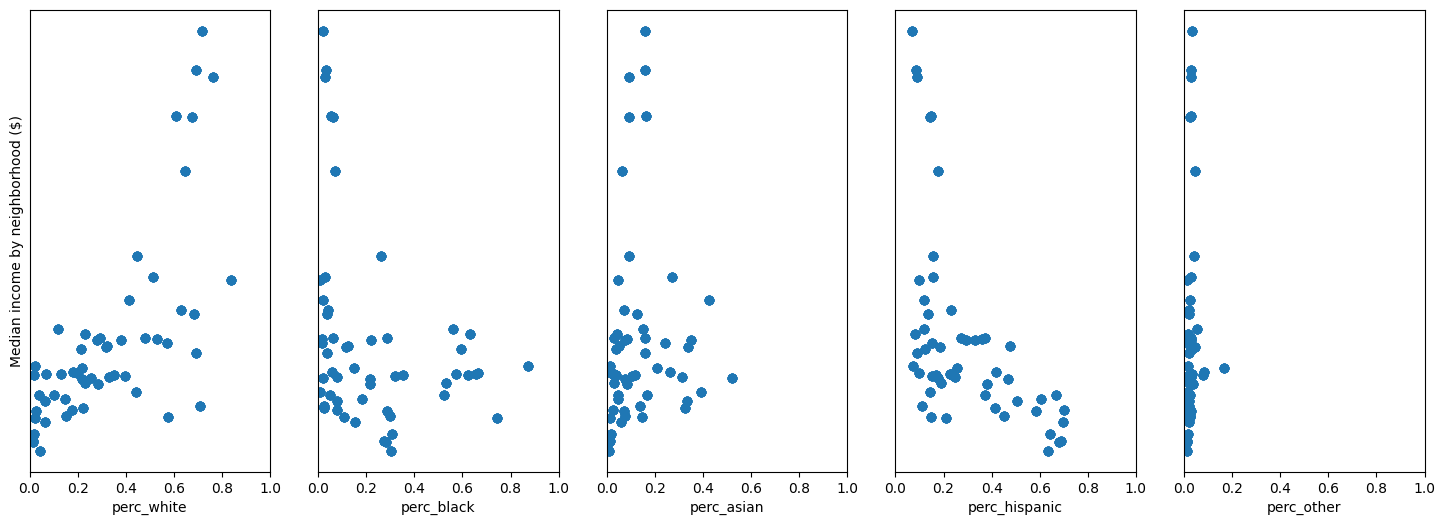

In [22]:
# Iterating over demographic groupings by ethinicity and plotting
ethnicities = ["white", "black", "asian", "hispanic", "other"]
f, axes = plt.subplots(1, 5, figsize=(18, 6), sharey=True, squeeze=True)

for i, e in enumerate(zip(axes, ethnicities)):
    
    axis = e[0]
    ethnicity_label = f"perc_{e[1]}"

    # Plot median income vs percentage of population
    axis.scatter(df[ethnicity_label], df.median_income)
    axis.set_xlim(0, 1)
    axis.set_xlabel(ethnicity_label)

    if i > 0:
        axis.set_yticks([])

axes[0].set_ylabel("Median income by neighborhood ($)")

### Crime data
There is crime data available for [NYC in this open dataset](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243). We can 

## Conclusion
While the data used in this project can't prove causality, it's interesting to show (through both visualization and statistical testing)